# Monte Carlo methods - A Sandbox/Demo

Monte Carlo broadly refers to random sampling methods. Here we will focus mainly on Monte Carlo sampling in the context of molecular simulations, but it's worth briefly considering an example of Monte Carlo integration. Particularly, we can use Monte Carlo integration to calculate $\pi$ with just a few lines of code.

## Preparation 

To use this notebook you will either need to run it locally using Jupyter (with a fortran library you pre-compile) or on Google Colab. This notebook briefly explains either route, though if you are going the local route you may need to compile the library before installing some of the other course materials, or do so in a clean/new conda environment. Some users have reported that conda installing `openforcefield`, `openmm` and the openeye toolkits after installing `gfortran` results in the loss of the ability to compile fortran libraries for use in Python.


### Preparation for Google Colab (NOT FOR LOCAL USE)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/MC/MC_Sandbox.ipynb)

For Google Colab, pip installation of software is faster, but we've only been able to get `gfortran` working via a conda installation, so we'll need to go that route. Begin by unsetting the PYTHONPATH to prevent issues with miniconda, then installing miniconda (which will take perhaps 20 seconds to a couple of minutes):

In [ ]:
%env PYTHONPATH=
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.10.3-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

Once that is done, install `gfortran`, which will take roughly a similar amount of time:

In [ ]:
!conda install -c conda-forge libgfortran --yes

Next, mount your Google Drive and ensure you have the mc_sandbox.f90 file available **at a path you define below**:

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

#EDIT THIS TO DEFINE WHERE YOU PUT THE FILE:
md_library_path = '/content/drive/MyDrive/drug-computing/uci-pharmsci/lectures/MC/'

# Then run:
%cd $md_library_path

Then compile the requisite library:

In [ ]:
!f2py3 -c -m mc_sandbox mc_sandbox.f90

### Preparation for local use

For local use, you need to compile the fortran module `mc_sandbox` for use as a Python library. This accelerates the numerical calculations and a similar framework will be used in the MD and MC assignments. Use `f2py3 -c -m mc_sandbox mc_sandbox.f90` to compile. (As noted above you may need to do this in advance of installing certain modules, such as the beginning of the course, or by making a clean conda environment.)

## Calculating $\pi$ via MC integration

So, let's calculate $\pi$ by doing MC integration. Particularly, let's consider a drawing random numbers between -1 and 1, and then imagine a circle centered at (0, 0). Consider the area of that circle (of radius 1) to that of the full square spanned by our random numbers (2 units wide). Particularly, if $R$ is the radius of the circle, then the ratio of the areas is:
\begin{equation}
\frac{A_{sq}}{A_{cir}} = \frac{(2R)^2}{\pi R^2} = \frac{4}{\pi} 
\end{equation}

so we find
\begin{equation}
\pi = \frac{4 A_{cir}}{A_{sq}}
\end{equation}

So, if we randomly place points in an interval -1 to 1, and then check to see how many fall within a square versus within a circle, we can use the ratio of counts (related to the ratio of the areas) to determine $\pi$.

In [1]:
#Import modules we need
import numpy
import numpy.random

#Number of data points to sample
Ntrials = 1000

#Randomly generate array of XY positions - spanning -1 to 1
XY = 2.*numpy.random.rand( Ntrials, 2)-1.

#Compute distance from each point to center of the circle
distances = numpy.sqrt( numpy.sum( XY*XY, axis=1))

#Find indices of data points which are within the unit circle
#Note that you could code this in a more straightforward - but slower - way by setting up a 
#'for' loop over data points and checking to see where the distance is less than 1.
indices_inside = numpy.where( distances < 1)

#Find how many points are here
num_inside = len( indices_inside[0] )

#Calculate estimate of pi
pi_estimate = 4.*num_inside/float(Ntrials)
print(pi_estimate)

3.152


### Let's take a look at what we've done here, graphically. 
We can plot the points inside and outside in two different colors to see.

Populating the interactive namespace from numpy and matplotlib


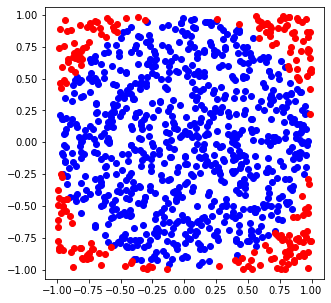

In [2]:
%pylab inline

#After the code above, indices_inside has the numbers of points which are inside our unit circle.
#We would also like indices of points which are outside the unit circle
indices_outside = numpy.where( distances > 1)

#Make our plot of points inside and outside using circles for the data points
#blue for inside, red for outside
plot(XY[indices_inside[0],0], XY[indices_inside[0],1], 'bo')
plot(XY[indices_outside[0],0], XY[indices_outside[0],1], 'ro')

#Adjust plot settings to look nicer
axis('equal') #Set to have equal axes
F = pylab.gcf() #Get handle of current figure
F.set_size_inches(5,5) #Set size to be square (default view is rectangular)

#Bonus: Drawing a unit circle on the graph is up to you

# Let's revisit the LJ particles we saw in the MD sandbox

In our last sandbox, we looked at molecular dynamics on a pair of Lennard-Jones particles. Now let's revisit that, but within the Metropolis Monte Carlo framework. Optionally, you could make things a little more interesting here by considering an extra particle. But for now let's just start with the same two particles as last time to make visualization easy.. 

Here, we'll apply the Metropolis MC framework as discussed in lecture, where every step we:
* Randomly pick a particle
* Change each of x, y, and z a small amount between $-\Delta r_{max}$ and $\Delta r_{max}$
* Compute the energy change $\Delta U$
* Apply the Metropolis criterion to decide whether to accept the move or reject it
  * If $\Delta U < 0$, accept the move
  * If $\Delta U > 0$, accept with the probability $P_{acc} = e^{-\Delta U/T}$
* If accepted, keep the new configuration
* Regardless of whether we accept it or not, update any running averages with the current state and energy


## Let's run some MC 

(As noted above, you will need to have compiled the `mc_sandbox` Fortran library before doing this, using either the appropriate technique for local work or for on Colab.)

### First, we set up our system:

In [5]:
import mc_sandbox
import numpy as np
import numpy.random

#Let's define the variables we'll need
Cut = 2.5
L = 3.0 #Let's put these in a small box so they don't lose each other
max_displacement = 0.1 #Maximum move size
T = 1. #You should play with this and see how the results change. Don't make it an integer - use a floating point value (i.e. 1., not 1)

#Choose N for number of particles; you could adjust this later.
N = 2

#Allocate position array - initially just zeros
Pos = np.zeros((N,3), float)

#Let's place the first two particles just as we did in MD Sandbox:
Pos[0,:] = np.array([0,0,0])
#We'll place the second one fairly nearby - at this point using the same starting location
#as in the MD sandbox
Pos[1,:] = np.array([1.5,0,0])

#If you have any other particles, let's just place them randomly
for i in range(2,N):
    Pos[i,:] = L*np.random.random( 3 )

### Now let's run a step of MC!

In [6]:
#Set maximum number of steps to run
max_steps = 10000

#Set up storage for position vs step
Pos_t = np.zeros(( N,3,max_steps), float)
#Store initial positions
Pos_t[:,:,0] = Pos

#Evaluate initial energy
U = mc_sandbox.calcenergy(Pos, L, Cut)

#Pick a random particle
num = np.random.randint(N) #Random integer from 0 up to but not including N

#Store old position in case we need to revert
#Note that it's necessary here to make a copy, otherwise both still point to the same 
#coordinates (try OldPos = Pos to see).
OldPos = Pos.copy() 

#Pick a move - adjusting to make it between -DeltaX and +DeltaX
move = max_displacement * (np.random.random( 3)*2.-1.)

#Update position
Pos[num, :] += move

#Evaluate new energy
Unew = mc_sandbox.calcenergy( Pos, L, Cut)
DeltaU = Unew - U
print("U, Unew, DeltaU: ", U, Unew, DeltaU) #Just for debugging purposes so we can see what's happening.

#Print acceptance probability
Pacc = np.exp(-DeltaU/T)
print("Acceptance probability Pacc=", Pacc) #Just for debugging purposes so we can see what's happening.

#We can handle the uphill and downhill cases with a single 'if' statement
if np.random.rand() < Pacc:
    print("Accepted")  #Just for debugging purposes so we can see what's happening.
    U = Unew
else: #Revert
    Pos = OldPos
    print("Rejected") #Just for debugging purposes so we can see what's happening.


#Remember, at the end, if we are tracking energy, we update running averages/tracking data 
#with the current position and energy
Pos_t[:, :, 1] = Pos

U, Unew, DeltaU:  -0.3366534854145746 -0.42428826461302754 -0.08763477919845292
Acceptance probability Pacc= 1.0915893780702166
Accepted


## Now let's again define that get_r function so we can look at the separation between our particles over time
Last time, I was lazy and didn't handle the minimum image convention (in part because I knew we weren't giving the particles enough energy initially that they wouldn't fly apart). Here, because T (effectively, the kinetic energy) is an adjustable parameter we might end up with them flying apart, so we need to use the minimum image convention to properly measure the distance between particles. In other words, if a particle crosses the box edge and then finds the other particle and interacts with it, we want our distance measurement to notice that they are interacting rather than reporting that they are very distant. (The Fortran code we have is using this convention for its energy calculations).

So, we define a new get_r function which handles this:

In [7]:
def get_r(Pos, L):
    """Calculate r, the distance between particles, for a position array containing just two particles. Return it.
    Unlike in MD sandbox, here we also implement the minimum image convention"""
    
    #Get displacement
    disp = Pos[1,:] - Pos[0,:]
    #Apply minimum image convention
    disp = disp - L*np.round(disp/L) 
    #Calculate distance
    d = np.sqrt( np.dot( disp, disp))
    return d

## Now, write your own code - adapting the code from above for a single step - to run an MC simulation of your pair of LJ particles

Because a little more code is required than for the MD assignment, I provide some comments guiding you through the steps you'll need to do. And I also provide code to generate a plot at the end.

Be sure to track the acceptance probability over all suggested moves. (This could be used to adjust the size of the moves you suggest).

In [ ]:
# Put your code here


In [ ]:
##GET READY TO PLOT
#Find x axis (MC steps rather than time, as it was in the MD sandbox)
t = np.arange(0,max_steps)
#Find y axis (r values)
r_vs_t = []
for i in range(max_steps):
    r=get_r(Pos_t[:,:,i], L)
    r_vs_t.append(r)

r_vs_t = np.array(r_vs_t)

#Plot
figure()
plot(t, r_vs_t)

## Other things to be sure to try
* See what happens if you adjust the temperature. Particularly, check what happens in the limit of T becoming very small (approaching zero). Are uphill moves ever accepted? What does an MC search end up doing?
* Try making the box size reasonably big and see what happens at a moderate temperature
* Adjust the move size (`max_displacement`) to make the acceptance probability 30-50%. How big can you make it? 

## Other things to try if you have extra time
* Check the probability distribution of separations and see how it varies with temperature. 